# Actions and Orbit caluclation with MC sampling for GALAH DR3

## Author: Sven Buder

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# General
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas
import astropy.io.fits as pyfits
from astropy.table import Table

# matplotlib
import matplotlib.pyplot as plt
debug = False #True

### Galpy initialization

In [2]:
import galpy
from galpy.potential import MWPotential2014 as pot
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords

#galpy scale units:                                                                                                                                                                                         
_REFR0 = 8.2   #[kpc]  --> galpy length unit                                                                                                                                                                 
_REFV0 = 238. #[km/s] --> galpy velocity unit

aAS = actionAngleStaeckel(
        pot   = pot,        #potential                                                                                                                                                                      
        delta = 0.45,       #focal length of confocal coordinate system                                                                                                                            
        c     = True        #use C code (for speed)                                                                                                                                                         
        )

print("The Sun has an angular momentum of '+str(_REFR0 * _REFV0)+' kpc km/s in this action framework with MWPotential2014")

#Galactocentric position of the Sun according to Bland-Hawthorn & Gerhard (2016)
X_gc_sun_kpc = 8.2   #[kpc]                                                                                                                                                                                 
Z_gc_sun_kpc = 0.025 #[kpc]                                                                                                                                                                                 

print(r"We place Sgr A at (x; y; z) = (R_0; 0; z_0) kpc, where")
print("R_0 = 8.2 kpc and z_0 = -25 pc (Bland-Hawthorn & Gerhard, 2016)")

#Galactocentric velocity of the Sun:                                                                                                                                                                        
vX_gc_sun_kms = -11.0        # = -U              [kms]                                                                                                                                                      
vY_gc_sun_kms =  10.0+_REFV0 # = V+v_circ(R_Sun) [kms]                                                                                                                                                      
vZ_gc_sun_kms =   7.25       # = W               [kms]                                                                                                                                                      

print("The Sun's velocity with respect to a co-located particle on a circular orbit is")
print("V_LSR = (U_sun, V_sun, W_sun) = (-11, 10, 7.25) km/s (Schoenrich 2012)")

The Sun has an angular momentum of '+str(_REFR0 * _REFV0)+' kpc km/s in this action framework with MWPotential2014
We place Sgr A at (x; y; z) = (R_0; 0; z_0) kpc, where
R_0 = 8.2 kpc and z_0 = -25 pc (Bland-Hawthorn & Gerhard, 2016)
The Sun's velocity with respect to a co-located particle on a circular orbit is
V_LSR = (U_sun, V_sun, W_sun) = (-11, 10, 7.25) km/s (Schoenrich 2012)


### Input of 6D information in observable dimensions

In [3]:
# Where is sobject_iraf_53_2MASS_GaiaDR2_WISE_PanSTARRSDR1_BailerJones_K2seis.fits?

file_directory = '/shared-storage/buder/svn-repos/trunk/GALAH/DATA/'
#file_directory = '/Users/buder/GALAH_DR3/input/'

In [4]:
galah_gaia_input = pyfits.getdata(file_directory+'sobject_iraf_53_2MASS_GaiaDR2_WISE_PanSTARRSDR1_BailerJones_K2seis.fits',1)
                                  
nr_galah_stars = len(galah_gaia_input['sobject_id'])
print(nr_galah_stars)

nr_galah_stars_dynamics = np.where(
    np.isfinite(galah_gaia_input['ra']) &
    np.isfinite(galah_gaia_input['dec']) &
    np.isfinite(galah_gaia_input['r_est']) &
    np.isfinite(galah_gaia_input['pmra']) &
    np.isfinite(galah_gaia_input['pmdec']) &
    np.isfinite(galah_gaia_input['rv_guess']) &
    np.isfinite(galah_gaia_input['ra_error']) &
    np.isfinite(galah_gaia_input['dec_error']) &
    np.isfinite(galah_gaia_input['r_hi']) &
    np.isfinite(galah_gaia_input['r_lo']) &
    np.isfinite(galah_gaia_input['pmra_error']) &
    np.isfinite(galah_gaia_input['pmdec_error']) &
    np.isfinite(galah_gaia_input['e_rv_guess']) &
    (galah_gaia_input['rv_guess'] != 999.) &
    (galah_gaia_input['rv_guess'] != 1024.)
    )[0]

# This should only me activated for tests with subsets of GALAH DR3
nr_galah_stars_dynamics = nr_galah_stars_dynamics[:20]

galah_gaia = galah_gaia_input[nr_galah_stars_dynamics]
nr_stars = len(galah_gaia['sobject_id'])
print(nr_stars)

825531
20


In [5]:
six_dimensions = {}

# Right ascension [rad]
six_dimensions['ra'] = galah_gaia['ra']*(np.pi/180.)
# Declination [rad]
six_dimensions['dec'] = galah_gaia['dec']*(np.pi/180.)
# Distance from Sun [kpc]
six_dimensions['distance'] = galah_gaia['r_est']#/1000.

# Total proper motion in direction of right ascension [mas/yr]
six_dimensions['pmra'] = galah_gaia['pmra'] * np.cos(six_dimensions['dec'])
# Total proper motion in direction of declination [mas/yr]
six_dimensions['pmdec'] = galah_gaia['pmdec']
# Radial velocity [km/s]
six_dimensions['vrad'] = galah_gaia['rv_guess']

In [6]:
e_six_dimensions = {}

# Error of right ascension [rad]
e_six_dimensions['ra'] = galah_gaia['ra_error']*(np.pi/180.)
# Error of declination [rad]
e_six_dimensions['dec'] = galah_gaia['dec_error']*(np.pi/180.)
# Error of distance from Sun [pc]
e_six_dimensions['distance_high'] = galah_gaia['r_hi']
e_six_dimensions['distance_low']  = galah_gaia['r_lo']
    # We are currently sampling a 2-sided Gaussian because Bailer-Jones are only giving 16th/50th/86th percentiles.
    # Any idea how to improve that because of missing posteriors from Bailer-Jones?
    
# Error of total proper motion in direction of right ascension [mas/yr]
e_six_dimensions['pmra'] = galah_gaia['pmra_error'] * np.cos(six_dimensions['dec'])
# Error of total proper motion in direction of declination [mas/yr]
e_six_dimensions['pmdec'] = galah_gaia['pmdec_error']
# Error of radial velocity [km/s]
e_six_dimensions['vrad'] = np.sqrt(galah_gaia['e_rv_guess']**2. + 0.1**2.) # error floor for rv_guess is 0.1 like for GALAH DR2

## Monte Carlo sampling of Orbits

In [7]:
MC_size = 10000
np.random.seed(123)

XYZ_labels       = ['X_XYZ','Y_XYZ','Z_XYZ']
UVW_labels       = ['U_LSR','V_LSR','W_LSR']

Rphiz_labels     = ['R_Rzphi','phi_Rzphi','z_Rzphi']
vRphiz_labels    = ['vR_Rzphi','vphi_Rzphi','vz_Rzphi']

action_labels    = ['J_R','L_Z','J_Z']
ext_orbit_labels = ['ecc', 'zmax', 'R_peri', 'R_ap']

orbit_labels = np.concatenate((
    XYZ_labels,
    UVW_labels,
    Rphiz_labels,
    vRphiz_labels,
    action_labels,
    ext_orbit_labels    
    ))
print(orbit_labels)

orbit_information = {}
interim_orbit_information = {}

for each_orbit_label in orbit_labels:
    interim_orbit_information[each_orbit_label] = []
    interim_orbit_information[each_orbit_label+'_sig'] = []

['X_XYZ' 'Y_XYZ' 'Z_XYZ' 'U_LSR' 'V_LSR' 'W_LSR' 'R_Rzphi' 'phi_Rzphi'
 'z_Rzphi' 'vR_Rzphi' 'vphi_Rzphi' 'vz_Rzphi' 'J_R' 'L_Z' 'J_Z' 'ecc'
 'zmax' 'R_peri' 'R_ap']


### Samples

In [8]:
# Sampling the distances from Bailer-Jones assuming 2 separate Gaussian distributions
distance_sigma_lo  = np.array([np.abs(np.random.normal(loc = 0., scale = six_dimensions['distance'] -  e_six_dimensions['distance_low'])) for i in range(MC_size)])
distance_sigma_hi  = np.array([np.abs(np.random.normal(loc = 0., scale = e_six_dimensions['distance_high'] - six_dimensions['distance'])) for i in range(MC_size)])
select_lo_hi = np.array([(np.random.uniform(0, 1, size=nr_stars) < 0.5).astype(float) for x in range(MC_size)])

In [9]:
MC_sample_6D = {}

if MC_size == 1:
    for each_key in six_dimensions.keys():
        MC_sample_6D[each_key] = np.array([six_dimensions[each_key]])
else:
    MC_sample_6D['ra']       = np.array([np.random.normal(loc=six_dimensions['ra'], scale=e_six_dimensions['ra']) for i in range(MC_size)])
    MC_sample_6D['dec']      = np.array([np.random.normal(loc=six_dimensions['dec'], scale=e_six_dimensions['dec']) for i in range(MC_size)])
    MC_sample_6D['distance'] = (six_dimensions['distance'] + select_lo_hi*distance_sigma_hi - (1-select_lo_hi)*distance_sigma_lo).clip(min=0)/1000.

    MC_sample_6D['pmra']       = np.array([np.random.normal(loc=six_dimensions['pmra'], scale=e_six_dimensions['pmra']) for i in range(MC_size)])
    MC_sample_6D['pmdec']      = np.array([np.random.normal(loc=six_dimensions['pmdec'], scale=e_six_dimensions['pmdec']) for i in range(MC_size)])
    MC_sample_6D['vrad']      = np.array([np.random.normal(loc=six_dimensions['vrad'], scale=e_six_dimensions['vrad']) for i in range(MC_size)])

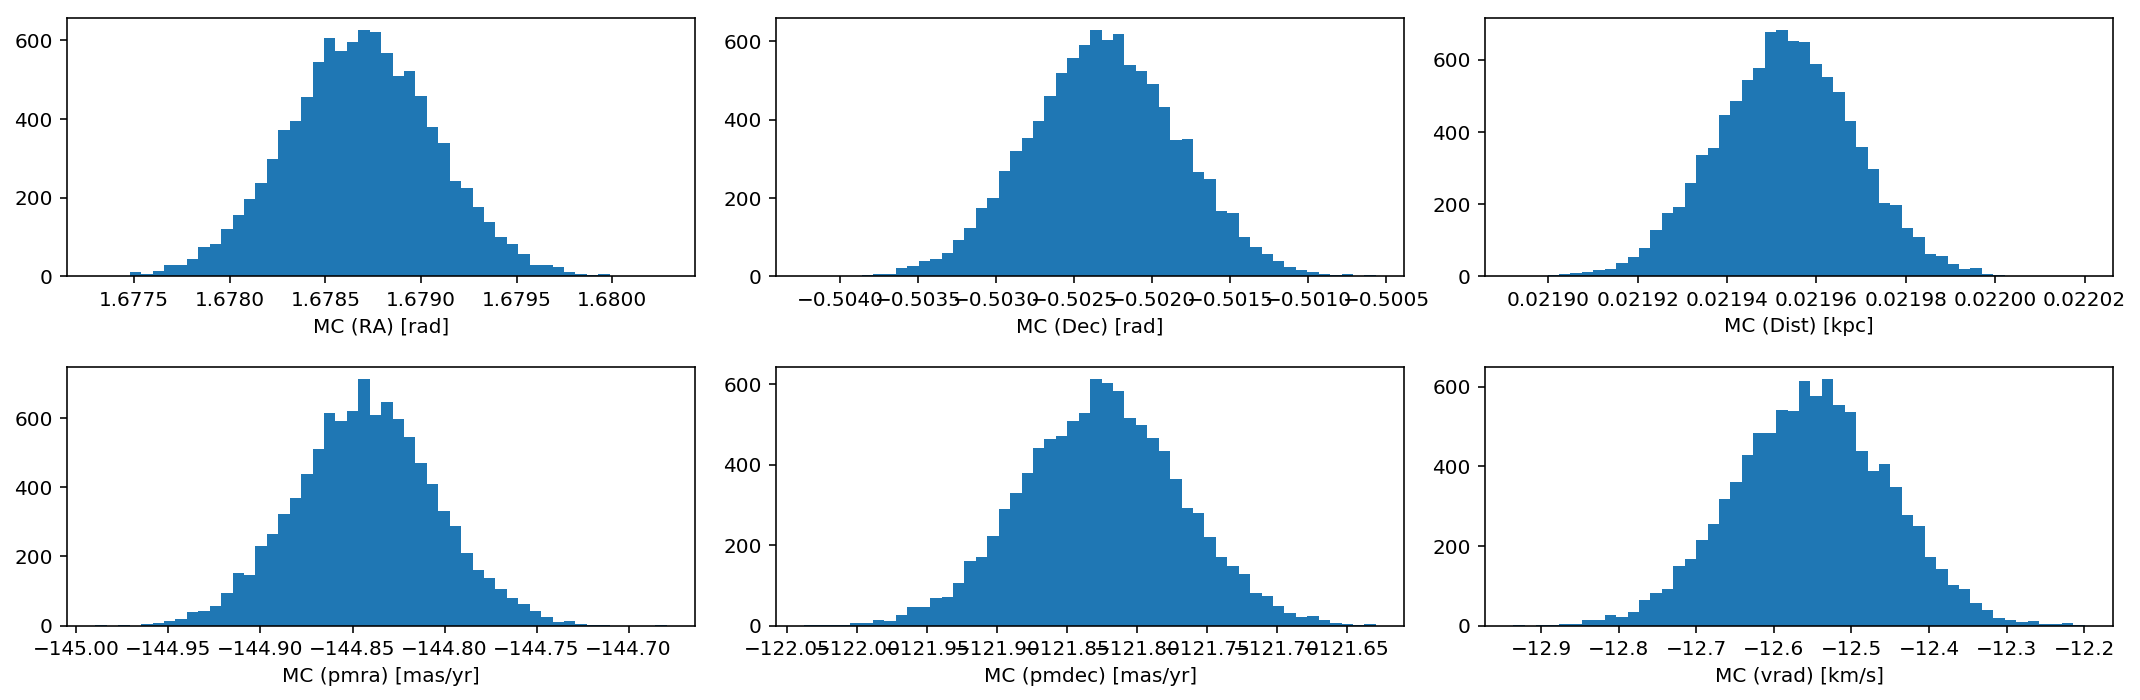

In [ ]:
if (debug == True):
    star_index = 0

    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(15,5))

    ax1.hist(MC_sample_6D['ra'][:,star_index],bins=50);
    ax2.hist(MC_sample_6D['dec'][:,star_index],bins=50);
    ax3.hist(MC_sample_6D['distance'][:,star_index],bins=50);

    ax4.hist(MC_sample_6D['pmra'][:,star_index],bins=50);
    ax5.hist(MC_sample_6D['pmdec'][:,star_index],bins=50);
    ax6.hist(MC_sample_6D['vrad'][:,star_index],bins=50);

    ax1.set_xlabel('MC (RA) [rad]')
    ax2.set_xlabel('MC (Dec) [rad]')
    ax3.set_xlabel('MC (Dist) [kpc]')
    ax4.set_xlabel('MC (pmra) [mas/yr]')
    ax5.set_xlabel('MC (pmdec) [mas/yr]')
    ax6.set_xlabel('MC (vrad) [km/s]')

    plt.tight_layout()

In [ ]:
for each_draw in range(MC_size):
    
    #a. convert spatial coordinates (ra,dec,d) to (R,z,phi)
    
    #(ra,dec) --> Galactic coordinates (l,b):  
    lb = bovy_coords.radec_to_lb(
                    MC_sample_6D['ra'][each_draw],MC_sample_6D['dec'][each_draw],
                    degree=False,epoch='J2015.5'
                    )
    
    # (l,b,d) --> Galactocentric cartesian coordinates (x,y,z):  
    xyz = bovy_coords.lbd_to_XYZ(
                    lb[:,0],lb[:,1],
                    MC_sample_6D['distance'][each_draw],
                    degree=False)
    
    interim_orbit_information[XYZ_labels[0]].append(xyz[:,0])
    interim_orbit_information[XYZ_labels[1]].append(xyz[:,1])
    interim_orbit_information[XYZ_labels[2]].append(xyz[:,2])
    
    # (x,y,z) --> Galactocentric cylindrical coordinates (R,phi,z):
    Rphiz= bovy_coords.XYZ_to_galcencyl(
                    xyz[:,0], xyz[:,1], xyz[:,2],
                    Xsun=X_gc_sun_kpc,Zsun=Z_gc_sun_kpc
                    )
    
    #b. convert velocities (pm_ra,pm_dec,vlos) to (vR,vz,vT)     
    pmlpmb = bovy_coords.pmrapmdec_to_pmllpmbb(
                        MC_sample_6D['pmra'][each_draw],
                        MC_sample_6D['pmdec'][each_draw],
                        MC_sample_6D['ra'][each_draw],
                        MC_sample_6D['dec'][each_draw],
                        degree=False,epoch='J2015.5'
                        )
    
    uvw = bovy_coords.vrpmllpmbb_to_vxvyvz(
                    MC_sample_6D['vrad'][each_draw],
                    pmlpmb[:,0],pmlpmb[:,1],
                    lb[:,0],lb[:,1],
                    MC_sample_6D['distance'][each_draw],
                    XYZ=False,degree=False
                    )
    
    interim_orbit_information[Rphiz_labels[0]].append(Rphiz[:,0])
    interim_orbit_information[Rphiz_labels[1]].append(Rphiz[:,1])
    interim_orbit_information[Rphiz_labels[2]].append(Rphiz[:,2])
    
    interim_orbit_information[UVW_labels[0]].append(uvw[:,0])
    interim_orbit_information[UVW_labels[1]].append(uvw[:,1])
    interim_orbit_information[UVW_labels[2]].append(uvw[:,2])

    vRphiz = bovy_coords.vxvyvz_to_galcencyl(
                    uvw[:,0],
                    uvw[:,1],
                    uvw[:,2],
                    Rphiz[:,0],
                    Rphiz[:,1],
                    Rphiz[:,2],
                    vsun=[vX_gc_sun_kms,vY_gc_sun_kms,vZ_gc_sun_kms],
                    galcen=True
                    )
    
    interim_orbit_information[vRphiz_labels[0]].append(vRphiz[:,0])
    interim_orbit_information[vRphiz_labels[1]].append(vRphiz[:,1])
    interim_orbit_information[vRphiz_labels[2]].append(vRphiz[:,2])
    

    jR,lz,jz = aAS(
        Rphiz[:,0]/_REFR0,
        vRphiz[:,0]/_REFV0,
        vRphiz[:,1]/_REFV0,
        Rphiz[:,2]/_REFR0,
        vRphiz[:,2]/_REFV0
    )
    
    interim_orbit_information[action_labels[0]].append(jR*_REFR0*_REFV0)
    interim_orbit_information[action_labels[1]].append(lz*_REFR0*_REFV0)
    interim_orbit_information[action_labels[2]].append(jz*_REFR0*_REFV0)
    
    ezr1, ezr2, ezr3, ezr4 = aAS.EccZmaxRperiRap(
        Rphiz[:,0]/_REFR0,
        vRphiz[:,0]/_REFV0,
        vRphiz[:,1]/_REFV0,
        Rphiz[:,1]/_REFR0,
        vRphiz[:,2]/_REFV0,
        Rphiz[:,2]
    )
    interim_orbit_information[ext_orbit_labels[0]].append(ezr1)
    interim_orbit_information[ext_orbit_labels[1]].append(ezr2*_REFR0)
    interim_orbit_information[ext_orbit_labels[2]].append(ezr3*_REFR0)
    interim_orbit_information[ext_orbit_labels[3]].append(ezr4*_REFR0)
    

In [ ]:
for each_orbit_label in orbit_labels:
    interim_orbit_information[each_orbit_label] = np.array(interim_orbit_information[each_orbit_label])
    try:
        orbit_information[each_orbit_label] = np.array([np.nanmean(interim_orbit_information[each_orbit_label][:,each_star]) for each_star in range(nr_stars)])
        orbit_information[each_orbit_label+'_sig'] = np.array([np.nanstd(interim_orbit_information[each_orbit_label][:,each_star]) for each_star in range(nr_stars)])
    except:
        print('no output for '+each_orbit_label)

if debug==True:
    
    star_index = 0
    
    print("XYZ = ({x:8.2f},{y:8.2f},{z:8.2f}) [kpc]".format(
        x=orbit_information[XYZ_labels[0]][star_index],
        y=orbit_information[XYZ_labels[1]][star_index],
        z=orbit_information[XYZ_labels[2]][star_index]
        ))
          
    print("UVW = ({u:8.2f},{v:8.2f},{w:8.2f}) [kpc km/s]".format(
        u=orbit_information[UVW_labels[0]][star_index],
        v=orbit_information[UVW_labels[1]][star_index],
        w=orbit_information[UVW_labels[2]][star_index]
        ))

    print("R   = {r:6.2f} +- {r_sig:6.2f} [kpc], phi = {phi:6.2f} +- {phi_sig:6.2f} [rad], z = {z:6.2f} +- {z_sig:6.2f} [kpc]".format(
        r=orbit_information[Rphiz_labels[0]][star_index],
        phi=orbit_information[Rphiz_labels[1]][star_index],
        z=orbit_information[Rphiz_labels[2]][star_index],
        r_sig=orbit_information[Rphiz_labels[0]+'_sig'][star_index],
        phi_sig=orbit_information[Rphiz_labels[1]+'_sig'][star_index],
        z_sig=orbit_information[Rphiz_labels[2]+'_sig'][star_index]
        ))
    print("J_R = {jr:6.2f} +- {jr_sig:6.2f}, L_Z = {lz:6.2f} +- {lz_sig:6.2f}, J_Z = {jz:6.2f} +- {jz_sig:6.2f} [kpc km/s]".format(
        jr=orbit_information['J_R'][star_index],
        jr_sig=orbit_information['J_R_sig'][star_index],
        lz=orbit_information['L_Z'][star_index],
        lz_sig=orbit_information['L_Z_sig'][star_index],
        jz=orbit_information['J_Z'][star_index],
        jz_sig=orbit_information['J_Z_sig'][star_index]
        ))

In [ ]:
if debug==True:
    errorbar_kwargs = dict(fmt='o')
    
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(15,5))

    ax1.errorbar(
        orbit_information[XYZ_labels[0]],
        orbit_information[XYZ_labels[1]],
        xerr=orbit_information[XYZ_labels[0]+'_sig'],
        yerr=orbit_information[XYZ_labels[1]+'_sig'],
        **errorbar_kwargs
    )
    ax1.set_xlabel('X (XYZ) [kpc]')
    ax1.set_ylabel('Y (XYZ) [kpc]')
    
    ax2.errorbar(
        orbit_information[Rphiz_labels[0]],
        orbit_information[Rphiz_labels[2]],
        xerr=orbit_information['R_Rzphi_sig'],
        yerr=orbit_information['z_Rzphi_sig'],
        **errorbar_kwargs
    )
    ax2.set_xlabel('R (GC) [kpc]')
    ax2.set_ylabel('z (GC) [kpc]')

    ax3.errorbar(
        orbit_information[UVW_labels[1]],
        np.sqrt(orbit_information[UVW_labels[0]]**2 + orbit_information[UVW_labels[2]]**2),
        xerr=orbit_information[UVW_labels[1]+'_sig'],
        yerr=np.sqrt(orbit_information[UVW_labels[0]+'_sig']**2 + orbit_information[UVW_labels[2]+'_sig']**2),
        **errorbar_kwargs
    )
    ax3.set_xlabel('Toomre V (LSR) [km/s]')
    ax3.set_ylabel('Toomre UW (LSR) [km/s]')

    ax4.errorbar(
        orbit_information[ext_orbit_labels[0]],
        orbit_information[ext_orbit_labels[1]],
        xerr=orbit_information[ext_orbit_labels[0]+'_sig'],
        yerr=orbit_information[ext_orbit_labels[1]+'_sig'],
        **errorbar_kwargs
    )
    ax4.set_xlabel('Eccentricity')
    ax4.set_ylabel('z_max [kpc]')

    ax5.errorbar(
        orbit_information[ext_orbit_labels[2]],
        orbit_information[ext_orbit_labels[3]],
        xerr=orbit_information[ext_orbit_labels[2]+'_sig'],
        yerr=orbit_information[ext_orbit_labels[3]+'_sig'],
        **errorbar_kwargs
    )
    ax5.set_xlabel('R (pericenter) [kpc]')
    ax5.set_ylabel('R (apocenter) [kpc]')

    ax6.errorbar(
        orbit_information[action_labels[1]],
        np.sqrt(orbit_information[action_labels[0]]),
        xerr=orbit_information[action_labels[1]+'_sig'],
        yerr=[np.sqrt(orbit_information[action_labels[0]]+orbit_information[action_labels[0]+'_sig']) - np.sqrt(orbit_information[action_labels[0]]),np.sqrt(orbit_information[action_labels[0]]) - np.sqrt(orbit_information[action_labels[0]]-orbit_information[action_labels[0]+'_sig'])],
        **errorbar_kwargs
    )
    ax6.set_xlabel('L_Z [kpc km/s]')
    ax6.set_ylabel('sqrt(J_R [kpc km/s])')

    plt.tight_layout()

In [ ]:
galah_dynamics = {}

galah_dynamics['sobject_id'] = galah_gaia_input['sobject_id']
for each_orbit_label in orbit_labels:
    galah_dynamics[each_orbit_label] = np.zeros(nr_galah_stars, dtype=float)
    galah_dynamics[each_orbit_label].fill(np.nan)
    galah_dynamics[each_orbit_label+'_sig'] = np.zeros(nr_galah_stars, dtype=float)
    galah_dynamics[each_orbit_label+'_sig'].fill(np.nan)

    (galah_dynamics[each_orbit_label])[nr_galah_stars_dynamics] = orbit_information[each_orbit_label]
    (galah_dynamics[each_orbit_label+'_sig'])[nr_galah_stars_dynamics] = orbit_information[each_orbit_label+'_sig']

    
galah_dynamics_data = pandas.DataFrame(galah_dynamics,columns=galah_dynamics.keys())
galah_dynamics_data

data_for_fits = Table.from_pandas(galah_dynamics_data)
data_for_fits.write('sobject_dynamics.fits',overwrite=True)

In [ ]:
import email
import email.mime.application
from email.MIMEMultipart import MIMEMultipart
from email.MIMEText import MIMEText
from email.MIMEImage import MIMEImage
msg = MIMEMultipart()

msg['From'] = 'gemini2'
msg['To'] = 'buder@mpia.de'
msg['Subject'] = 'Orbit calculation for GALAH DR3 finished'                                                                                                         

import smtplib
mailer = smtplib.SMTP('localhost')
mailer.sendmail('gemini2', 'buder@mpia.de', msg.as_string())
mailer.close()
print('Email sent')